In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy


Cargo datasets de train, test, y las clases fine (100) y coarse (20).

Divido por 255 para normalizar el RGB a algo entre 0.0 y 1.0

In [84]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")
y_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [85]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)

In [86]:
indices_train = np.arange(len(x_train))
np.random.shuffle(indices_train)

x_train = x_train[indices_train]
y_train = y_train[indices_train]

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import numpy as np
%matplotlib inline

## preprocessing & augmentation

In [51]:
from imgaug import augmenters as iaa
from keras.utils import to_categorical
import random

In [87]:
train_images = x_train.astype('float32')/255
test_images = x_test.astype('float32')/255

# train_labels = to_categorical(y_train)
train_labels = y_train

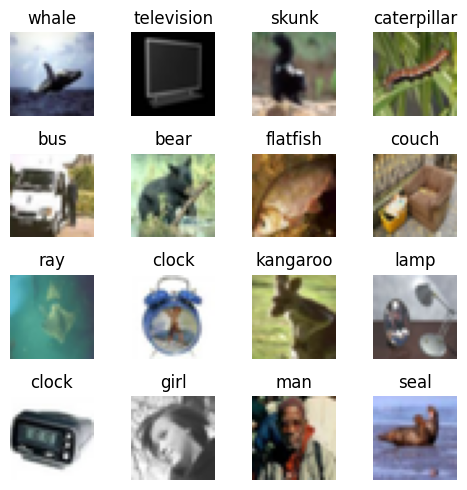

In [88]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(train_images[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [140]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.CropAndPad(px=(-3, 3),sample_independently=True,pad_mode=["constant", "edge"]),
    iaa.Affine(shear=(-10, 10),mode = ['symmetric','wrap']),#48
    iaa.Affine(rotate=(-25,25)), # random degree
    iaa.Add((-0.15, 0.15), per_channel=0.33),
    iaa.Multiply((0.85, 1.15), per_channel=0.33),
    iaa.Affine(translate_px={"x": (-5, 5)}),
    iaa.Affine(translate_px={"y": (-5, 5)}),
#     iaa.AdditiveGaussianNoise(scale=(0.0,0.1)),
    iaa.Crop(percent=(0, 0.15)),
#     iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255))
#     iaa.AddElementwise((-0.025, 0.025), per_channel=0.33),
    iaa.Cutout(fill_mode="gaussian", nb_iterations=(1, 3), size=0.15, fill_per_channel=True),
    iaa.Dropout(p=(0, 0.15), per_channel=0.5),
    iaa.ClipCBAsToImagePlanes()

],random_order=True)

In [118]:
# # reshape images to RGB scale with width & height are size 32
# x_train_proc = x_train.reshape(50000, 32 * 32 * 3)
# x_test_proc = x_test.reshape(10000, 32 * 32 * 3)

# # normalization to avoid gradient explode or vanish
# x_train_proc = x_train_proc.astype("float32")
# x_test_proc = x_test_proc.astype("float32")
# x_train_proc /= 255.0
# x_test_proc /= 255.0

In [141]:
aug_test = seq.augment_images(train_images[:1000])

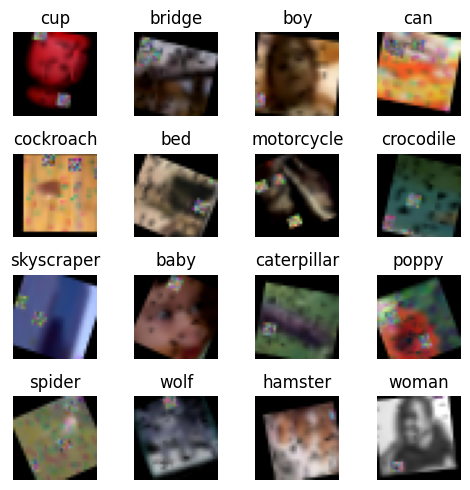

In [142]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 1000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(aug_test[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [143]:
train_images_aug1 = seq.augment_images(train_images)

In [144]:
train_images_aug2 = seq.augment_images(train_images)

In [ ]:
# train_images_aug3 = seq.augment_images(train_images)

In [145]:
train_images_aug_all = []
train_images_aug_all.extend(train_images)
train_images_aug_all.extend(train_images_aug1)
train_images_aug_all.extend(train_images_aug2)

In [146]:
train_labels_aug_all = []
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)

In [147]:
print(len(train_images_aug_all))
print(len(train_labels_aug_all))

150000
150000


In [148]:
train_images_final = []
train_labels_final = []

combined = list(zip(train_images_aug_all, train_labels_aug_all))
random.shuffle(combined)

train_images_final[:], train_labels_final[:] = zip(*combined)

In [150]:
train_images_final = np.asarray(train_images_final)
train_labels_final = np.asarray(train_labels_final)

In [156]:
# with open('train_images_final.pkl', 'wb') as f:
#     pickle.dump(train_images_final, f)

# with open('train_labels_final.pkl', 'wb') as f:
#     pickle.dump(train_labels_final, f)
    
    
    
# with open('train_images_final.pkl', 'rb') as f:
#     train_images_final = pickle.load(f)

# with open('train_labels_final.pkl', 'rb') as f:
#     train_labels_final = pickle.load(f)

In [151]:
print(train_images_final.shape)
print(train_labels_final.shape)

(150000, 32, 32, 3)
(150000,)


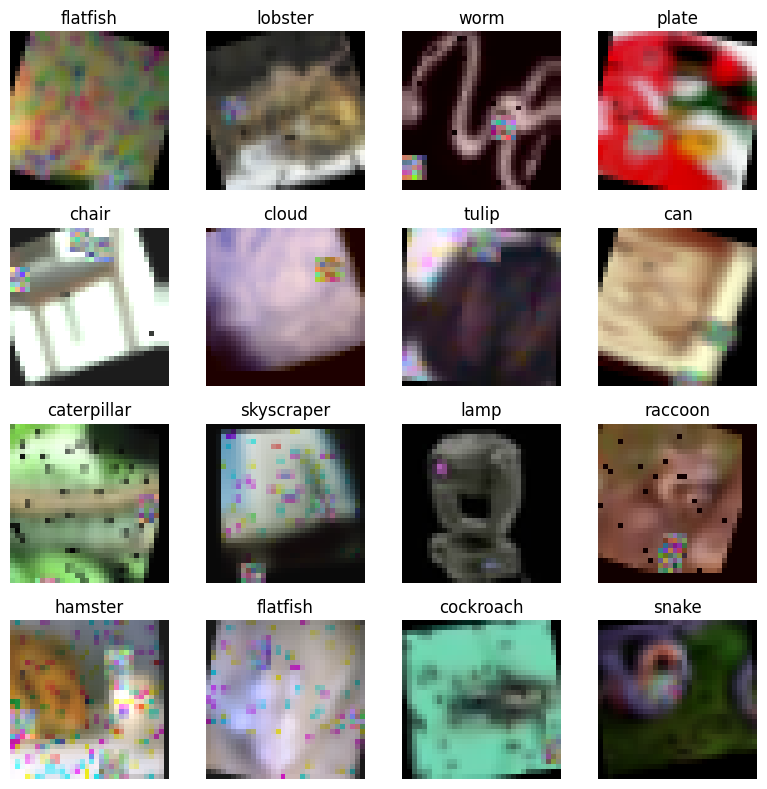

In [154]:
plt.figure(figsize=(8, 8))
for i in range(16):
    rand_num = np.random.randint(0, 150000)
    cifar_img = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images_final[rand_num])
 
    plt.title(labels_fine[train_labels_final[rand_num]]) 
    plt.axis('off')

plt.tight_layout()
plt.show()

## CNNModel

In [175]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import collections

In [176]:
all_history = collections.defaultdict(dict)

In [205]:
num_epochs = 200
batch_size = 128
base_lr = 0.001

In [206]:
model = Sequential()

# CNN
# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='swish'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())

# Classifier
model.add(Flatten())
model.add(Dense(64, activation='swish'))
model.add(Dense(100, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=base_lr), metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [184]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [185]:
mc = ModelCheckpoint(
    ".weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [186]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 5, 
    verbose = 1,
    restore_best_weights = True,
)

In [190]:
train_labels_final_tweak = to_categorical(train_labels_final)
print(train_labels_final_tweak.shape)
print(train_images_final.shape)

(150000, 100)
(150000, 32, 32, 3)


In [ ]:
history = model.fit(x=train_images_final, y=train_labels_final_tweak, batch_size=batch_size, epochs=num_epochs, validation_split=0.2, callbacks=[rlrop, es, mc])

Epoch 1/200
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.0933 - loss: 4.0767
Epoch 1: val_accuracy improved from -inf to 0.16850, saving model to .weights.h5
938/938 ━━━━━━━━━━━━━━━━━━━━ 194s 204ms/step - accuracy: 0.0933 - loss: 4.0764 - val_accuracy: 0.1685 - val_loss: 3.5441 - learning_rate: 0.0010
Epoch 2/200
319/938 ━━━━━━━━━━━━━━━━━━━━ 1:54 185ms/step - accuracy: 0.1978 - loss: 3.3814

In [48]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [49]:
all_history['case_1_train'] = history.history

In [50]:
print('Train loss:', all_history['case_1_train']['loss'][-1])
print('Train acc:', all_history['case_1_train']['accuracy'][-1])

Train loss: 2.9130094051361084
Train acc: 0.306674987077713


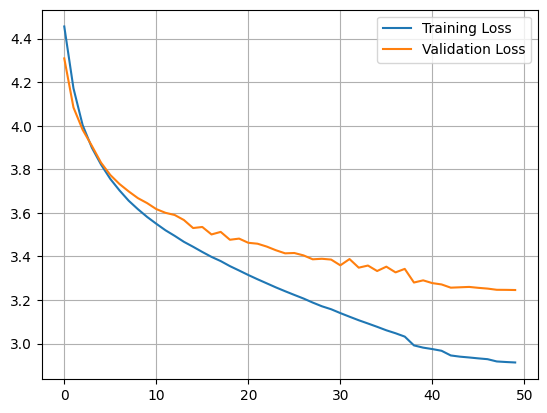

In [51]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()

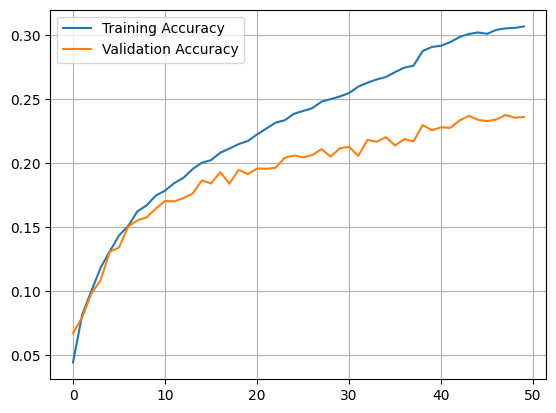

In [52]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.grid()
plt.legend()

In [65]:
predictions = model.predict(x_test_proc).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


In [66]:
print(predictions.shape)
print(predictions[1])

(10000,)
80


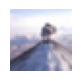

Prediction (fine): bridge




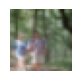

Prediction (fine): squirrel




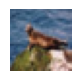

Prediction (fine): camel




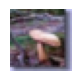

Prediction (fine): clock




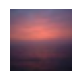

Prediction (fine): sea




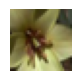

Prediction (fine): bee




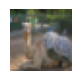

Prediction (fine): possum




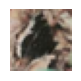

Prediction (fine): beetle




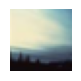

Prediction (fine): sea




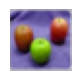

Prediction (fine): bowl




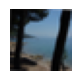

Prediction (fine): television




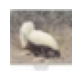

Prediction (fine): skunk




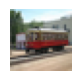

Prediction (fine): pickup_truck




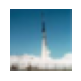

Prediction (fine): rocket




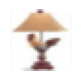

Prediction (fine): lamp




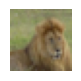

Prediction (fine): lion




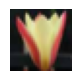

Prediction (fine): tulip




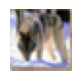

Prediction (fine): chair




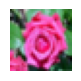

Prediction (fine): rose




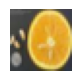

Prediction (fine): orange




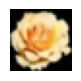

Prediction (fine): rose




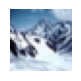

Prediction (fine): rocket




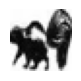

Prediction (fine): pickup_truck




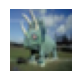

Prediction (fine): plain




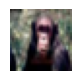

Prediction (fine): chimpanzee




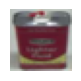

Prediction (fine): butterfly




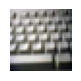

Prediction (fine): cloud




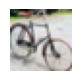

Prediction (fine): bicycle




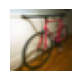

Prediction (fine): woman




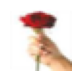

Prediction (fine): wardrobe




In [70]:
for i in range(30):
    plt.figure(figsize=(0.8, 0.8))
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.show()
    
    fine_pred = predictions[i]
    print("Prediction (fine):", labels_fine[fine_pred])
    print("\n")

In [69]:
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"
df.head()
df.to_csv("submission.csv")